# Grid Distillation Different Dataset Demos

In [8]:
import os

import numpy as np
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import grid_distillation_lib_demo as gd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [9]:
# print cuda devices
print("CUDA devices: ", torch.cuda.device_count())
print("CUDA device name: ", torch.cuda.get_device_name(0))

# select device and print info
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(0)

CUDA devices:  1
CUDA device name:  NVIDIA GeForce GTX 1650 Ti


_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650 Ti', major=7, minor=5, total_memory=4095MB, multi_processor_count=16)

# Demo

In [10]:

# Load the dataset
digits = load_digits()
X = digits.images
y = digits.target

# Normalize the images
X = X / 255.0

# Reshape the images to (n_samples, 1, 8, 8)
X = X.reshape(-1, 1, 8, 8)

# Convert labels to torch tensors
y = torch.tensor(y, dtype=torch.long)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train and evaluate the original model
train(model, train_loader, criterion, optimizer, epochs=10)
original_accuracy = evaluate(model, test_loader)
print(f'Original Model Accuracy: {original_accuracy}%')


Epoch [1/10], Loss: 2.306633562511868
Epoch [2/10], Loss: 2.3030316405826143
Epoch [3/10], Loss: 2.301190895504422
Epoch [4/10], Loss: 2.2970584445529516
Epoch [5/10], Loss: 2.280805736117893
Epoch [6/10], Loss: 2.1842257764604356
Epoch [7/10], Loss: 1.8012145254347058
Epoch [8/10], Loss: 1.2597931173112658
Epoch [9/10], Loss: 0.9104610628551907
Epoch [10/10], Loss: 0.7176588257153829
Original Model Accuracy: 85.27777777777777%


## Grid

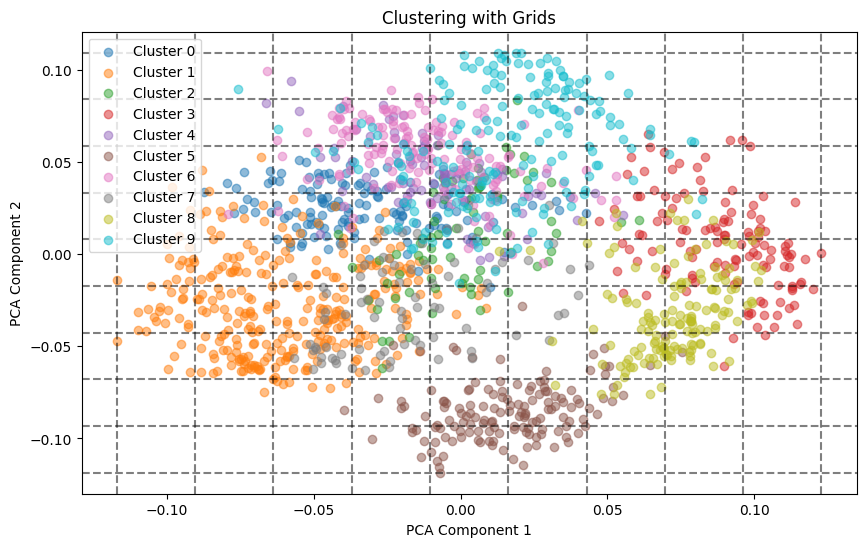

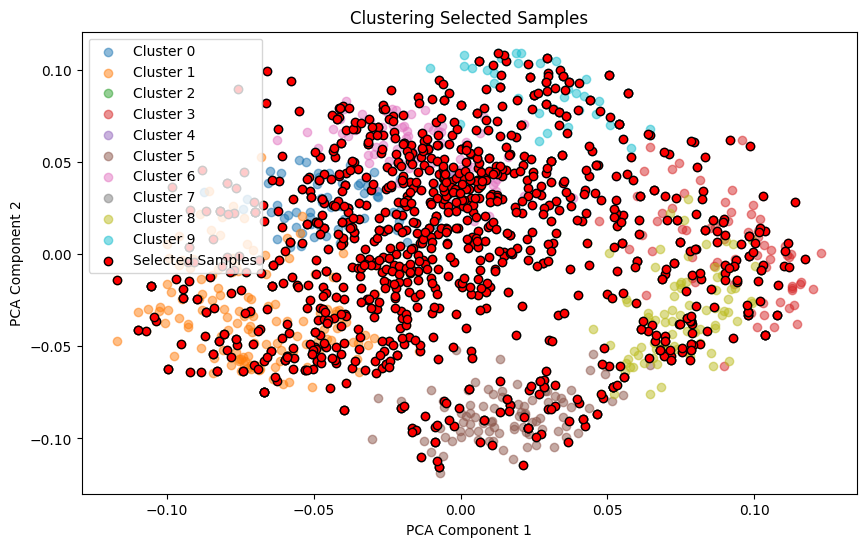

Epoch [1/10], Loss: 2.2916567831328423
Epoch [2/10], Loss: 2.2787316929210317
Epoch [3/10], Loss: 2.274482329686483
Epoch [4/10], Loss: 2.2699022220842764
Epoch [5/10], Loss: 2.2647956718098032
Epoch [6/10], Loss: 2.242888913010106
Epoch [7/10], Loss: 2.1853422540606875
Epoch [8/10], Loss: 2.035137895381812
Epoch [9/10], Loss: 1.7276383313265713
Epoch [10/10], Loss: 1.3726709033503677
Distilled Model Accuracy: 69.72222222222223%


In [11]:
grid_sampler = gd.GridImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
grid_sampler.cluster_images()
grid_sampler.plot_clusters_with_grids()
selected_samples = grid_sampler.get_selected_samples()
grid_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')

## Paralelogram

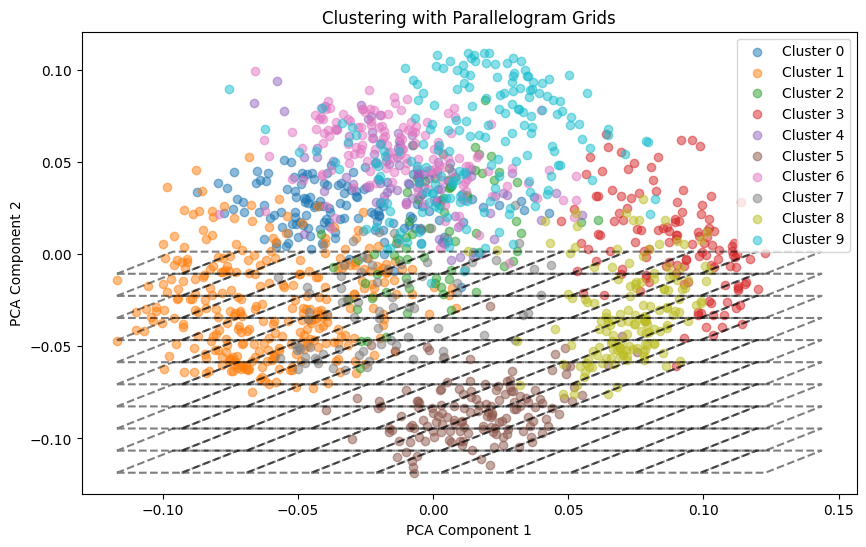

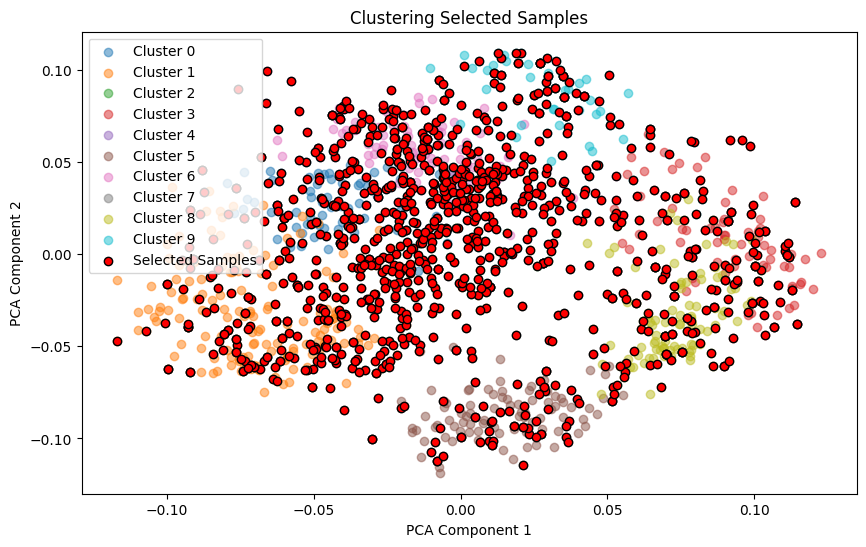

Epoch [1/10], Loss: 2.289971553918087
Epoch [2/10], Loss: 2.278543652910175
Epoch [3/10], Loss: 2.274603439099861
Epoch [4/10], Loss: 2.2700781460964317
Epoch [5/10], Loss: 2.258733930009784
Epoch [6/10], Loss: 2.226569652557373
Epoch [7/10], Loss: 2.134369337197506
Epoch [8/10], Loss: 1.9567092151352854
Epoch [9/10], Loss: 1.7396101662606904
Epoch [10/10], Loss: 1.5651503512353608
Distilled Model Accuracy: 39.44444444444444%


In [12]:

paralelogram_sampler = gd.ParallelogramImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
paralelogram_sampler.cluster_images()
paralelogram_sampler.plot_clusters_with_parallelograms()
selected_samples = paralelogram_sampler.get_selected_samples()
paralelogram_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')


## Triangular

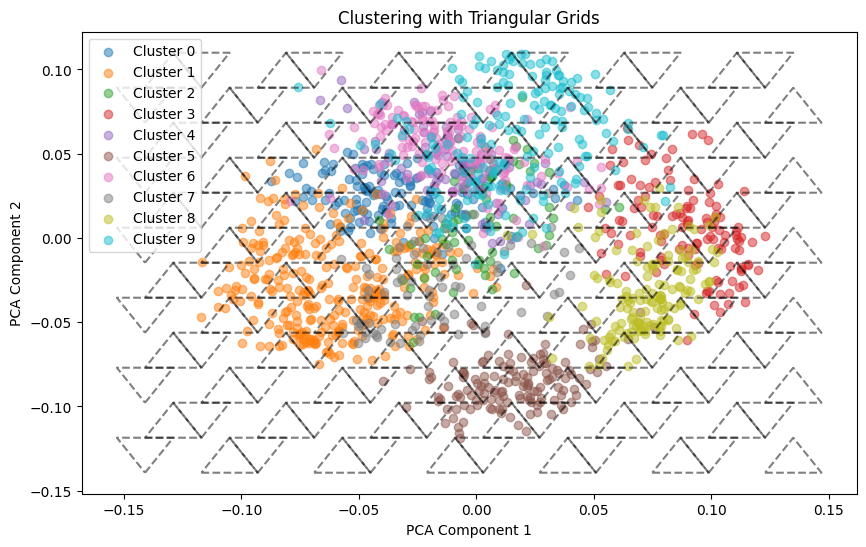

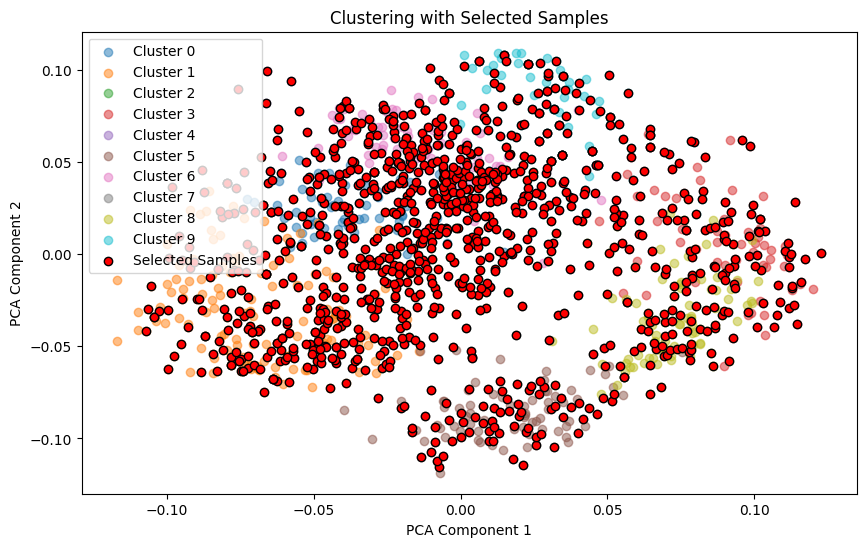

Epoch [1/10], Loss: 2.2974225607785312
Epoch [2/10], Loss: 2.2802922508933325
Epoch [3/10], Loss: 2.277308818065759
Epoch [4/10], Loss: 2.274311658107873
Epoch [5/10], Loss: 2.268729050954183
Epoch [6/10], Loss: 2.2600505207524155
Epoch [7/10], Loss: 2.2346164818966026
Epoch [8/10], Loss: 2.1648268121661562
Epoch [9/10], Loss: 2.008346210826527
Epoch [10/10], Loss: 1.81255452560656
Distilled Model Accuracy: 35.27777777777778%


In [13]:



triangle_sampler = gd.TriangularImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
triangle_sampler.cluster_images()
triangle_sampler.plot_clusters_with_triangles()
selected_samples = triangle_sampler.get_selected_samples()
triangle_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')


## Brick

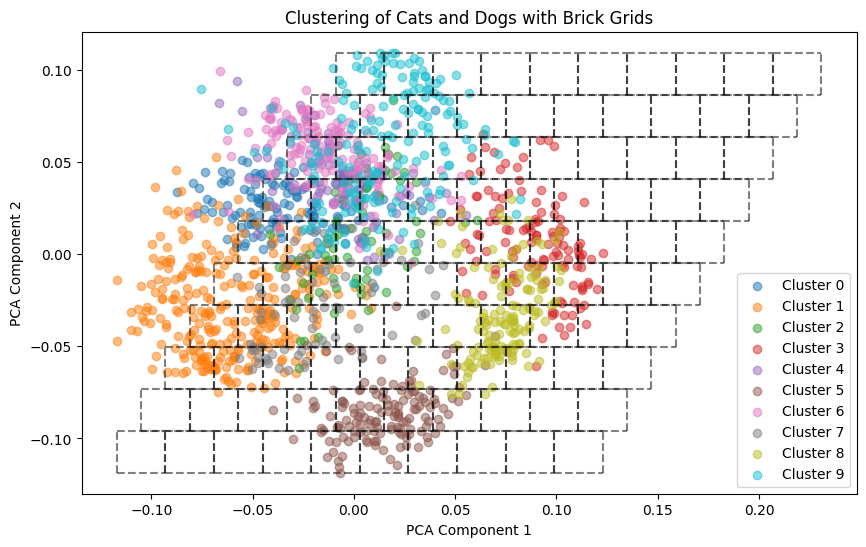

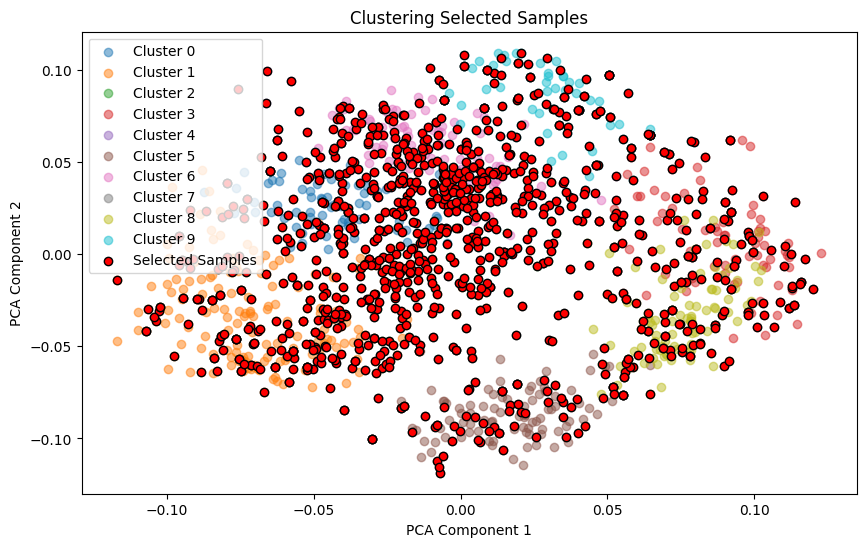

Epoch [1/10], Loss: 2.2914274316845518
Epoch [2/10], Loss: 2.279650001814871
Epoch [3/10], Loss: 2.2779732472968823
Epoch [4/10], Loss: 2.275587717692057
Epoch [5/10], Loss: 2.276668996521921
Epoch [6/10], Loss: 2.275273510904023
Epoch [7/10], Loss: 2.270357283678922
Epoch [8/10], Loss: 2.266956423268174
Epoch [9/10], Loss: 2.249096660903006
Epoch [10/10], Loss: 2.211152105620413
Distilled Model Accuracy: 11.666666666666666%


In [14]:
brick_sampler = gd.BrickImageClusterSampler(X_train, y_train, n_clusters=10, n_samples=75)
brick_sampler.cluster_images()
brick_sampler.plot_clusters_with_bricks()
selected_samples = brick_sampler.get_selected_samples()
brick_sampler.plot_selected_samples_on_clusters(selected_samples)

# Create a new dataset with the selected samples
X_train_distilled = X_train[selected_samples]
y_train_distilled = y_train[selected_samples]

# Create a DataLoader for the distilled dataset
train_distilled_dataset = TensorDataset(torch.tensor(X_train_distilled, dtype=torch.float32), y_train_distilled)
train_distilled_loader = DataLoader(train_distilled_dataset, batch_size=32, shuffle=True)

# Initialize a new model
distilled_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilled_model.parameters(), lr=0.001)

# Train the distilled model
train(distilled_model, train_distilled_loader, criterion, optimizer, epochs=10)
distilled_accuracy = evaluate(distilled_model, test_loader)
print(f'Distilled Model Accuracy: {distilled_accuracy}%')